#### Library imports / L5Kit setup

In [3]:
# PYTHON VERSION SHOULD BE 3.8.8
import sys
print(sys.version)

# NUMPY VERSION SHOULD BE 1.19.0
import numpy as np
np.version.version

3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]


'1.19.0'

In [4]:
import matplotlib.pyplot as plt

from l5kit.data import ChunkedDataset, LocalDataManager
from l5kit.dataset import EgoDataset, AgentDataset
from l5kit.rasterization import build_rasterizer
from l5kit.configs import load_config_data

import os

In [5]:
# opening the zarr_dataset
# os.environ["L5KIT_DATA_FOLDER"] = "../../prediction-dataset/"
os.environ["L5KIT_DATA_FOLDER"] = "../prediction-sample-dataset/"
cfg = load_config_data("./visualisation_config.yaml")
dm = LocalDataManager()
dataset_path = dm.require(cfg["val_data_loader"]["key"])
zarr_dataset = ChunkedDataset(dataset_path)
zarr_dataset.open()

In [6]:
# using EgoDataset interface to extract AV data
rast = build_rasterizer(cfg, dm)
ego_dataset = EgoDataset(cfg, zarr_dataset, rast)

In [7]:
scene_frame_indices = []
scene_frame_indices = zarr_dataset.scenes[:]["frame_index_interval"]

#### Linear Regression Function

Uses the points $x_{t-4}, x_{t-3}, ... x_{t}$ to predict $x_{t+1}$

Uses the points $y_{t-4}, y_{t-3}, ... y_{t}$ to predict $y_{t+1}$

(window_size is 5 in the example above)

In [8]:
def linearRegression(positions, window_size):
    """
    Use linear regression on the x and y positions to predict the position at the next timestep

    :positions: 2D-array of the (x,y) position data 
    :window_size: integer describing how many data points to use to predict the next timestep
    """
    predictions = []
    x_positions = [position[0] for position in positions]
    y_positions = [position[1] for position in positions]
    t = range(window_size)

    #for i in range(window_size, len(positions) - 1):
    for i in range(window_size, len(positions)):
        # use linear regression to predict next x-position
        coefficient = np.polyfit(t, x_positions[i + 1 - window_size : i + 1], 1)
        x = coefficient[0] * window_size + coefficient[1]

        # use linear regression to predict next y-position
        coefficient = np.polyfit(t, y_positions[i + 1 - window_size : i + 1], 1)
        y = coefficient[0] * window_size + coefficient[1]

        # combine results into predictions array
        predictions.append([x, y])

    return predictions

#### Multivariate Regression

P Auto-regressive model

Calculate confidence interval

In [9]:
def multivariateRegression(positions):
    pass

# timeseries
# p auto regressive
# Confidence Interval

#### Plotting functions

In [10]:
positions_alpha = 0.6
predictions_alpha = 0.6

def plotData(positions, predictions1, predictions2, predictions3, predictions4, predictions5):
    
    positions_x = [position[0] for position in positions]
    positions_y = [position[1] for position in positions]

    predictions_x1 = [position[0] for position in predictions1]
    predictions_y1 = [position[1] for position in predictions1]

    predictions_x2 = [position[0] for position in predictions2]
    predictions_y2 = [position[1] for position in predictions2]

    predictions_x3 = [position[0] for position in predictions3]
    predictions_y3 = [position[1] for position in predictions3]

    predictions_x4 = [position[0] for position in predictions4]
    predictions_y4 = [position[1] for position in predictions4]

    predictions_x5 = [position[0] for position in predictions5]
    predictions_y5 = [position[1] for position in predictions5]

    fig, axs = plt.subplots(2, 3, figsize=(15, 8))

    ax = plt.subplot(2, 3, 1)
    ax.scatter(positions_x, positions_y, label="Positions", s=5, alpha=1, color='c')
    ax.legend()
    ax.set_title("Positions")
    ax.set_xlabel("X position (m)")
    ax.set_ylabel("Y position (m)")
    # https://stackoverflow.com/questions/38855748/matplotlib-generating-strange-y-axis-on-certain-data-sets
    ax.get_yaxis().get_major_formatter().set_useOffset(False)

    ax1 = plt.subplot(2, 3, 2)
    ax1.scatter(positions_x, positions_y, label="Positions", s=5, alpha=positions_alpha, color='c')
    ax1.scatter(predictions_x1, predictions_y1, label="Predictions", s=5, alpha=predictions_alpha, color='m')

    ax2 = plt.subplot(2, 3, 3)
    ax2.scatter(positions_x, positions_y, label="Positions", s=5, alpha=positions_alpha, color='c')
    ax2.scatter(predictions_x2, predictions_y2, label="Predictions", s=5, alpha=predictions_alpha, color='m')

    ax3 = plt.subplot(2, 3, 4)
    ax3.scatter(positions_x, positions_y, label="Positions", s=5, alpha=positions_alpha, color='c')
    ax3.scatter(predictions_x3, predictions_y3, label="Predictions", s=5, alpha=predictions_alpha, color='m')

    ax4 = plt.subplot(2, 3, 5)
    ax4.scatter(positions_x, positions_y, label="Positions", s=5, alpha=positions_alpha, color='c')
    ax4.scatter(predictions_x4, predictions_y4, label="Predictions", s=5, alpha=predictions_alpha, color='m')

    ax5 = plt.subplot(2, 3, 6)
    ax5.scatter(positions_x, positions_y, label="Positions", s=5, alpha=positions_alpha, color='c')
    ax5.scatter(predictions_x5, predictions_y5, label="Predictions", s=5, alpha=predictions_alpha, color='m')

    for axis, title in zip([ax1, ax2, ax3, ax4, ax5], [2, 5, 10, 20, 50]): 
        axis.legend()
        axis.set_title(f"Linear regression {title}")
        axis.set_xlabel("X position (m)")
        axis.set_ylabel("Y position (m)")
        axis.get_yaxis().get_major_formatter().set_useOffset(False)
    
    plt.tight_layout()
    plt.show()

In [11]:
def plotScene(scene_number):
    positions = zarr_dataset.frames[slice(scene_frame_indices[scene_number][0], scene_frame_indices[scene_number][1])]["ego_translation"]
    positions = [[pos[0], pos[1]] for pos in positions]

    predictions2 = linearRegression(positions, 2)
    predictions5 = linearRegression(positions, 5)
    predictions10 = linearRegression(positions, 10)
    predictions20 = linearRegression(positions, 20)
    predictions50 = linearRegression(positions, 50)

    plotData(positions, predictions2, predictions5, predictions10, predictions20, predictions50)

#### Scene position/prediction plots

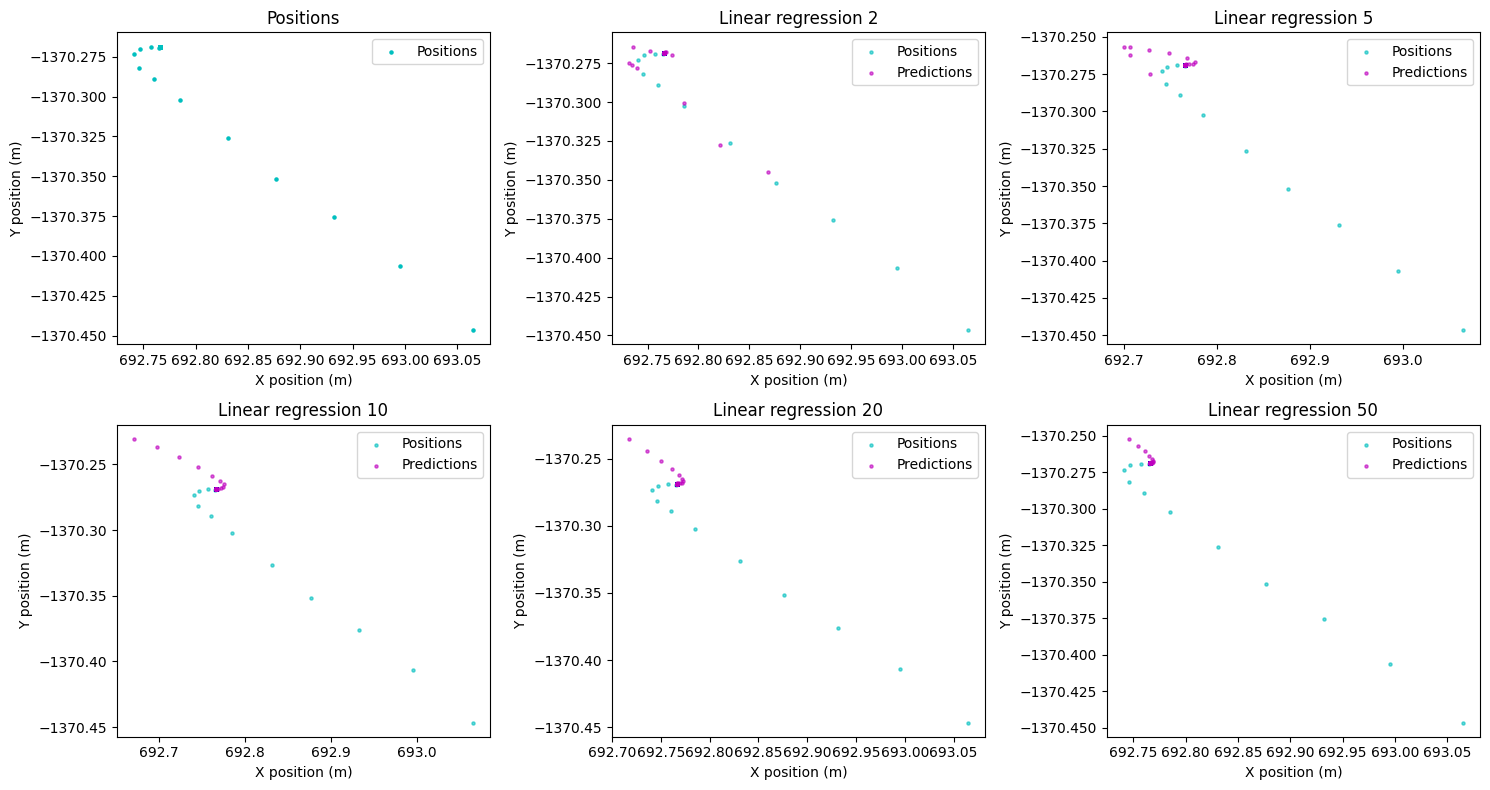

In [12]:
plotScene(2)

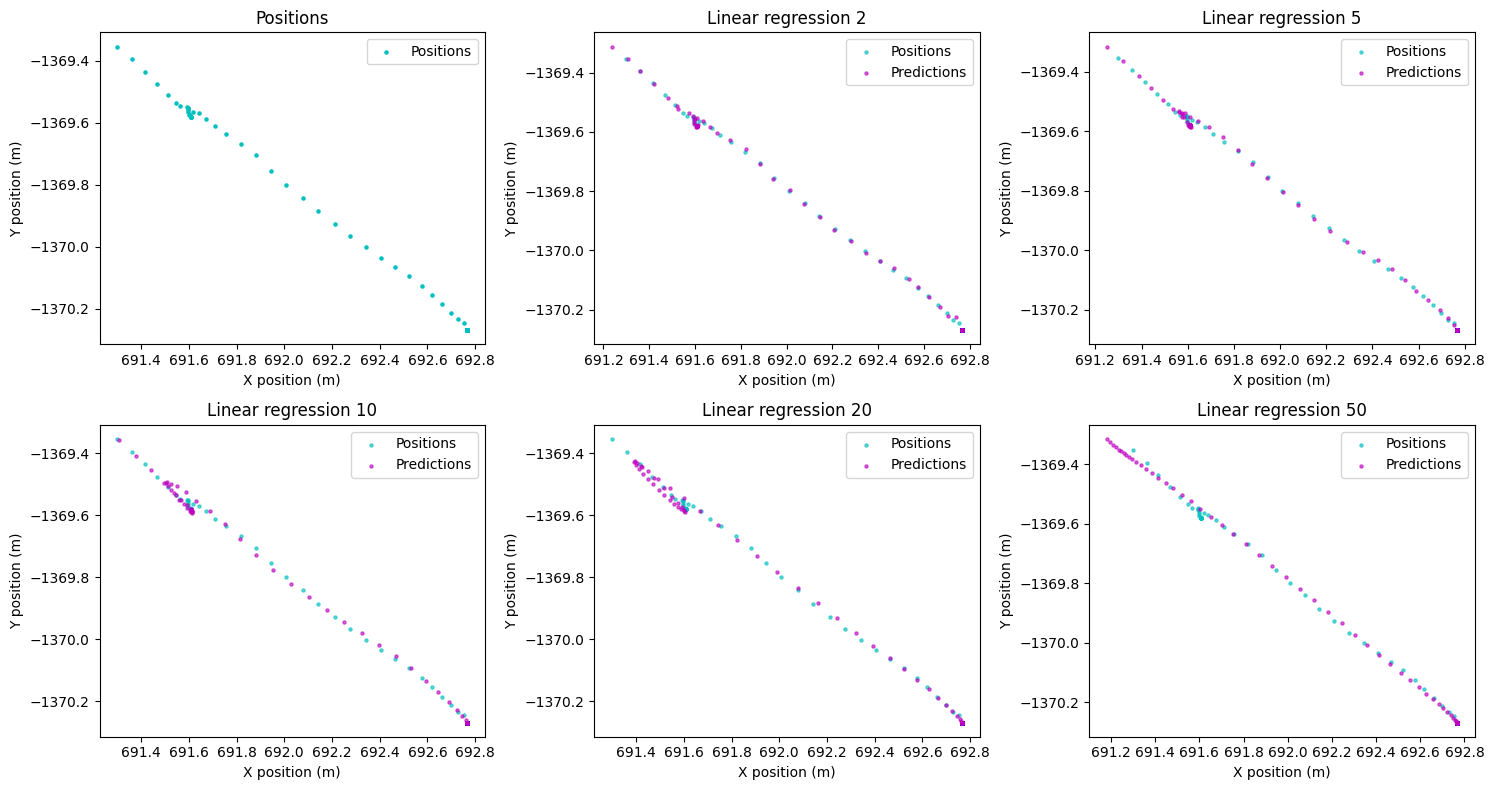

In [13]:
plotScene(5)

#### Mean-squared error

In [14]:
def mse(position, prediction):
    position = np.array(position)
    prediction = np.array(prediction)
    return np.square(np.subtract(position, prediction)).mean(axis=0)

#### 1/r weighted mean-squared error

In [15]:
# https://www.geeksforgeeks.org/how-to-implement-weighted-mean-square-error-in-python/#:~:text=Weighted%20mean%20square%20error%20enables,be%20a%20vital%20performance%20metric.
def oneRWmse(position, prediction):
    position = np.array(position)
    prediction = np.array(prediction)
    weights = np.array([1/(len(position)-x) for x in range(len(position))])
    weights = weights/weights.sum()
    weights = [[weight, weight] for weight in weights]

    return (np.square(np.subtract(position, prediction))*weights).sum(axis=0)

#### Rational weighted mean-squared error

In [16]:
def RWmse(position, prediction):
    position = np.array(position)
    prediction = np.array(prediction)
    weights = np.array([x/(x+1) for x in range(1, len(position) + 1)])
    weights = weights/weights.sum()
    weights = [[weight, weight] for weight in weights]

    return (np.square(np.subtract(position, prediction))*weights).sum(axis=0)

#### Calculating error

In [28]:
mse_values2 = []
oneRWmse_values2 = []
RWmse_values2 = []

mse_values5 = []
oneRWmse_values5 = []
RWmse_values5 = []

mse_values10 = []
oneRWmse_values10 = []
RWmse_values10 = []

mse_values20 = []
oneRWmse_values20 = []
RWmse_values20 = []

mse_values50 = []
oneRWmse_values50 = []
RWmse_values50 = []

all_positions = zarr_dataset.frames[:]["ego_translation"]

for scene in scene_frame_indices:
    positions = [[pos[0], pos[1]] for pos in all_positions[scene[0]:scene[1]]]

    predictions2 = linearRegression(positions, 2)
    mse_values2.append([mse(positions[2:], predictions2)[0], mse(positions[2:], predictions2)[1]])
    oneRWmse_values2.append([oneRWmse(positions[2:], predictions2)[0], oneRWmse(positions[2:], predictions2)[1]])
    RWmse_values2.append([RWmse(positions[2:], predictions2)[0], RWmse(positions[2:], predictions2)[1]])

    predictions5 = linearRegression(positions, 5)
    mse_values5.append([mse(positions[5:], predictions5)[0], mse(positions[5:], predictions5)[1]])
    oneRWmse_values5.append([oneRWmse(positions[5:], predictions5)[0], oneRWmse(positions[5:], predictions5)[1]])
    RWmse_values5.append([RWmse(positions[5:], predictions5)[0], RWmse(positions[5:], predictions5)[1]])

    predictions10 = linearRegression(positions, 10)
    mse_values10.append([mse(positions[10:], predictions10)[0], mse(positions[10:], predictions10)[1]])
    oneRWmse_values10.append([oneRWmse(positions[10:], predictions10)[0], oneRWmse(positions[10:], predictions10)[1]])
    RWmse_values10.append([RWmse(positions[10:], predictions10)[0], RWmse(positions[10:], predictions10)[1]])

    predictions20 = linearRegression(positions, 20)
    mse_values20.append([mse(positions[20:], predictions20)[0], mse(positions[20:], predictions20)[1]])
    oneRWmse_values20.append([oneRWmse(positions[20:], predictions20)[0], oneRWmse(positions[20:], predictions20)[1]])
    RWmse_values20.append([RWmse(positions[20:], predictions20)[0], RWmse(positions[20:], predictions20)[1]])

    predictions50 = linearRegression(positions, 50)
    mse_values50.append([mse(positions[50:], predictions50)[0], mse(positions[50:], predictions50)[1]])
    oneRWmse_values50.append([oneRWmse(positions[50:], predictions50)[0], oneRWmse(positions[50:], predictions50)[1]])
    RWmse_values50.append([RWmse(positions[50:], predictions50)[0], RWmse(positions[50:], predictions50)[1]])

#### Histograms

In [29]:
x_error2 = [error[0] for error in mse_values2]
y_error2 = [error[1] for error in mse_values2]

x_error_r2 =  [error[0] for error in oneRWmse_values2]
y_error_r2 =  [error[1] for error in oneRWmse_values2]

x_error_p2 =  [error[0] for error in RWmse_values2]
y_error_p2 =  [error[1] for error in RWmse_values2]

x_error5 = [error[0] for error in mse_values5]
y_error5 = [error[1] for error in mse_values5]

x_error_r5 =  [error[0] for error in oneRWmse_values5]
y_error_r5 =  [error[1] for error in oneRWmse_values5]

x_error_p5 =  [error[0] for error in RWmse_values5]
y_error_p5 =  [error[1] for error in RWmse_values5]

x_error10 = [error[0] for error in mse_values10]
y_error10 = [error[1] for error in mse_values10]

x_error_r10 =  [error[0] for error in oneRWmse_values10]
y_error_r10 =  [error[1] for error in oneRWmse_values10]

x_error_p10 =  [error[0] for error in RWmse_values10]
y_error_p10 =  [error[1] for error in RWmse_values10]

x_error20 = [error[0] for error in mse_values20]
y_error20 = [error[1] for error in mse_values20]

x_error_r20 =  [error[0] for error in oneRWmse_values20]
y_error_r20 =  [error[1] for error in oneRWmse_values20]

x_error_p20 =  [error[0] for error in RWmse_values20]
y_error_p20 =  [error[1] for error in RWmse_values20]

x_error50 = [error[0] for error in mse_values50]
y_error50 = [error[1] for error in mse_values50]

x_error_r50 =  [error[0] for error in oneRWmse_values50]
y_error_r50 =  [error[1] for error in oneRWmse_values50]

x_error_p50 =  [error[0] for error in RWmse_values50]
y_error_p50 =  [error[1] for error in RWmse_values50]

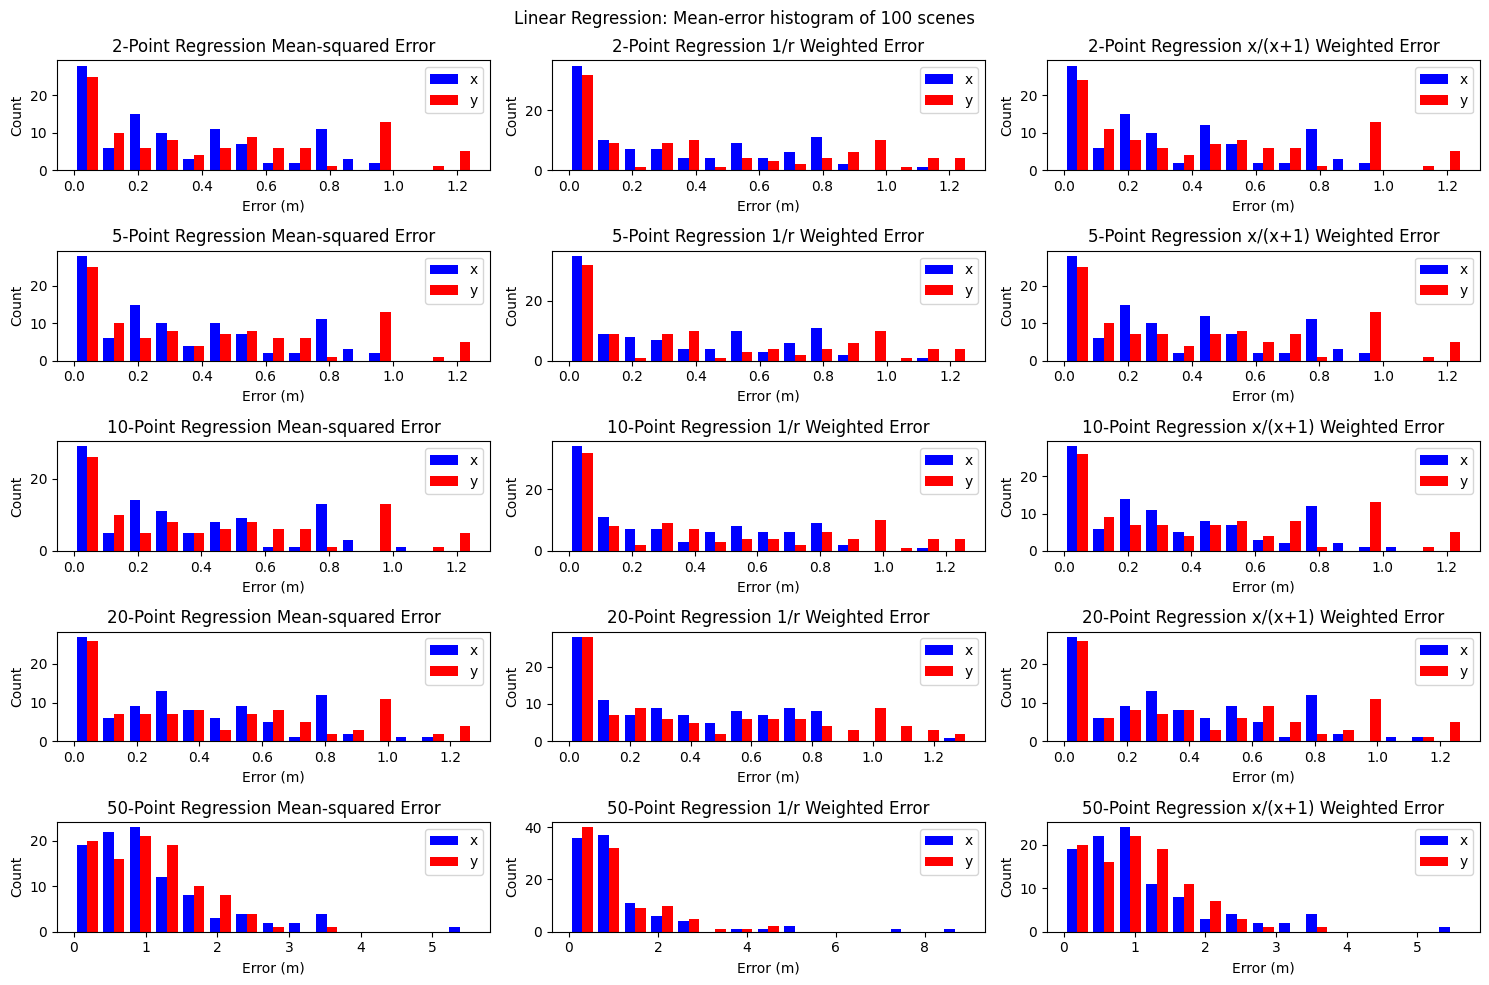

In [36]:
fig, axs = plt.subplots(5, 3, figsize=(15, 10))
fig.suptitle("Linear Regression: Mean-error histogram of 100 scenes")

ax1 = plt.subplot(5, 3, 1)
ax1.hist([x_error2, y_error2], label=['x', 'y'], color=['blue', 'red'], bins=15)
ax1.legend()
ax1.set_title("2-Point Regression Mean-squared Error")
ax1.set_xlabel("Error (m)")
ax1.set_ylabel("Count")
ax1.get_yaxis().get_major_formatter().set_useOffset(False)

ax2 = plt.subplot(5, 3, 2)
ax2.hist([x_error_r2, y_error_r2], label=['x', 'y'], color=['blue', 'red'], bins=15)
ax2.legend()
ax2.set_title("2-Point Regression 1/r Weighted Error")
ax2.set_xlabel("Error (m)")
ax2.set_ylabel("Count")
ax2.get_yaxis().get_major_formatter().set_useOffset(False)

ax3 = plt.subplot(5, 3, 3)
ax3.hist([x_error_p2, y_error_p2], label=['x', 'y'], color=['blue', 'red'], bins=15)
ax3.legend()
ax3.set_title("2-Point Regression x/(x+1) Weighted Error")
ax3.set_xlabel("Error (m)")
ax3.set_ylabel("Count")
ax3.get_yaxis().get_major_formatter().set_useOffset(False)

ax4 = plt.subplot(5, 3, 4)
ax4.hist([x_error5, y_error5], label=['x', 'y'], color=['blue', 'red'], bins=15)
ax4.legend()
ax4.set_title("5-Point Regression Mean-squared Error")
ax4.set_xlabel("Error (m)")
ax4.set_ylabel("Count")
ax4.get_yaxis().get_major_formatter().set_useOffset(False)

ax5 = plt.subplot(5, 3, 5)
ax5.hist([x_error_r5, y_error_r5], label=['x', 'y'], color=['blue', 'red'], bins=15)
ax5.legend()
ax5.set_title("5-Point Regression 1/r Weighted Error")
ax5.set_xlabel("Error (m)")
ax5.set_ylabel("Count")
ax5.get_yaxis().get_major_formatter().set_useOffset(False)

ax6 = plt.subplot(5, 3, 6)
ax6.hist([x_error_p5, y_error_p5], label=['x', 'y'], color=['blue', 'red'], bins=15)
ax6.legend()
ax6.set_title("5-Point Regression x/(x+1) Weighted Error")
ax6.set_xlabel("Error (m)")
ax6.set_ylabel("Count")
ax6.get_yaxis().get_major_formatter().set_useOffset(False)

ax7 = plt.subplot(5, 3, 7)
ax7.hist([x_error10, y_error10], label=['x', 'y'], color=['blue', 'red'], bins=15)
ax7.legend()
ax7.set_title("10-Point Regression Mean-squared Error")
ax7.set_xlabel("Error (m)")
ax7.set_ylabel("Count")
ax7.get_yaxis().get_major_formatter().set_useOffset(False)

ax8 = plt.subplot(5, 3, 8)
ax8.hist([x_error_r10, y_error_r10], label=['x', 'y'], color=['blue', 'red'], bins=15)
ax8.legend()
ax8.set_title("10-Point Regression 1/r Weighted Error")
ax8.set_xlabel("Error (m)")
ax8.set_ylabel("Count")
ax8.get_yaxis().get_major_formatter().set_useOffset(False)

ax9 = plt.subplot(5, 3, 9)
ax9.hist([x_error_p10, y_error_p10], label=['x', 'y'], color=['blue', 'red'], bins=15)
ax9.legend()
ax9.set_title("10-Point Regression x/(x+1) Weighted Error")
ax9.set_xlabel("Error (m)")
ax9.set_ylabel("Count")
ax9.get_yaxis().get_major_formatter().set_useOffset(False)

ax10 = plt.subplot(5, 3, 10)
ax10.hist([x_error20, y_error20], label=['x', 'y'], color=['blue', 'red'], bins=15)
ax10.legend()
ax10.set_title("20-Point Regression Mean-squared Error")
ax10.set_xlabel("Error (m)")
ax10.set_ylabel("Count")
ax10.get_yaxis().get_major_formatter().set_useOffset(False)

ax11 = plt.subplot(5, 3, 11)
ax11.hist([x_error_r20, y_error_r20], label=['x', 'y'], color=['blue', 'red'], bins=15)
ax11.legend()
ax11.set_title("20-Point Regression 1/r Weighted Error")
ax11.set_xlabel("Error (m)")
ax11.set_ylabel("Count")
ax11.get_yaxis().get_major_formatter().set_useOffset(False)

ax12 = plt.subplot(5, 3, 12)
ax12.hist([x_error_p20, y_error_p20], label=['x', 'y'], color=['blue', 'red'], bins=15)
ax12.legend()
ax12.set_title("20-Point Regression x/(x+1) Weighted Error")
ax12.set_xlabel("Error (m)")
ax12.set_ylabel("Count")
ax12.get_yaxis().get_major_formatter().set_useOffset(False)

ax13 = plt.subplot(5, 3, 13)
ax13.hist([x_error50, y_error50], label=['x', 'y'], color=['blue', 'red'], bins=15)
ax13.legend()
ax13.set_title("50-Point Regression Mean-squared Error")
ax13.set_xlabel("Error (m)")
ax13.set_ylabel("Count")
ax13.get_yaxis().get_major_formatter().set_useOffset(False)

ax14 = plt.subplot(5, 3, 14)
ax14.hist([x_error_r50, y_error_r50], label=['x', 'y'], color=['blue', 'red'], bins=15)
ax14.legend()
ax14.set_title("50-Point Regression 1/r Weighted Error")
ax14.set_xlabel("Error (m)")
ax14.set_ylabel("Count")
ax14.get_yaxis().get_major_formatter().set_useOffset(False)

ax15 = plt.subplot(5, 3, 15)
ax15.hist([x_error_p50, y_error_p50], label=['x', 'y'], color=['blue', 'red'], bins=15)
ax15.legend()
ax15.set_title("50-Point Regression x/(x+1) Weighted Error")
ax15.set_xlabel("Error (m)")
ax15.set_ylabel("Count")
ax15.get_yaxis().get_major_formatter().set_useOffset(False)

plt.tight_layout()
plt.show()